<a href="https://colab.research.google.com/github/BrainConnection/Dynamical_Decoupling_Project/blob/main/5.%20Measurement%20Induced%20Dephasing%20(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Environment Setting



In [1260]:
!pip install qutip
!pip install numpy
!pip install matplotlib
!pip install scipy

In [1261]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.optimize import curve_fit

# shelter

In [ ]:
corr1 = correlation_2op_1t(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    readout_number_dressed,
    readout_number_dressed,
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd}
)

In [ ]:
corr2 = correlation_2op_1t(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    sp_dressed,
    sp_dressed.dag(),
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd}
)

# CP CPMG UDD XY4 XY8 XY16 Sequence

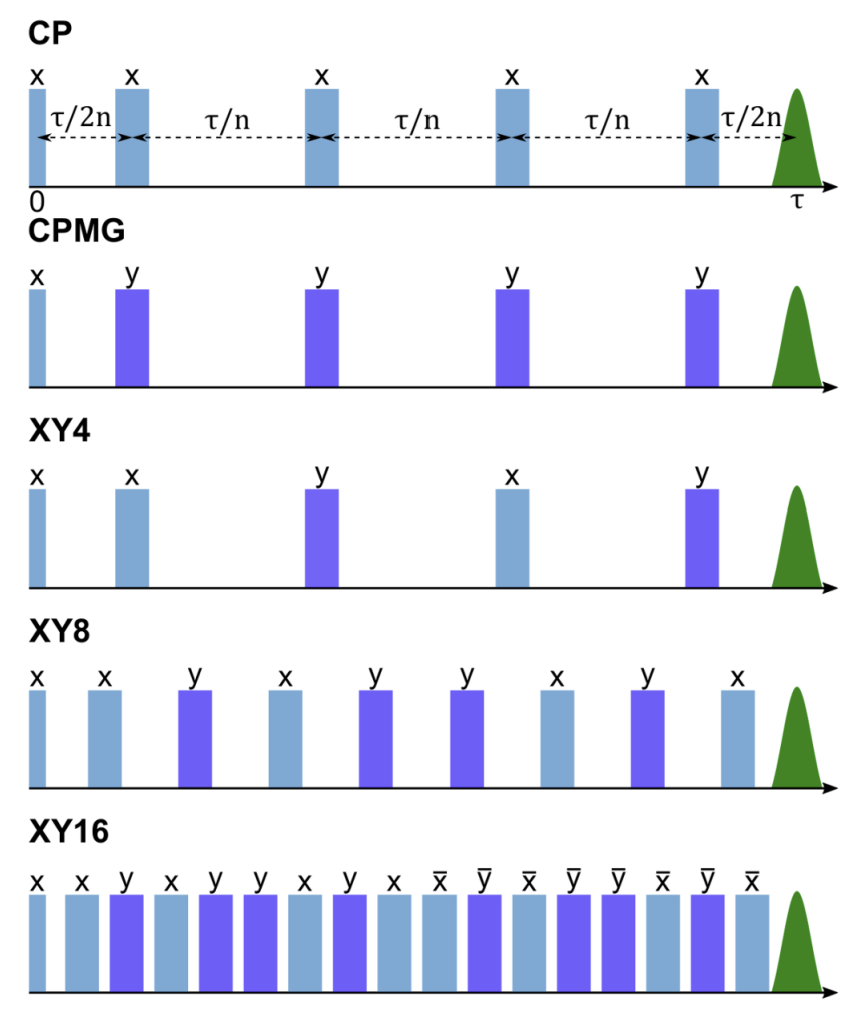

In [1262]:
# Modulate each pulse timing (Equivalent Spacing)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = []
    for i in range(N):
      Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq


# Modulate each pulse timing (Sinusoidal Spacing)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing_UDD(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = []

    shift = 0
    for i in range(N):
      shift = shift + T * np.sin(np.pi/(2*(N+2))) * np.sin(np.pi*(i+1)/(N+2)) / np.cos(np.pi/(2*(N+2)))
      Seq_list.append(T_srt + shift)

    Seq = np.array(Seq_list)

    return Seq

In [1263]:
# Single Square Pulse Envolope

def Single_pulse_env(t, B, T_cent):

    return B * (t > T_cent-0.5*np.pi/B) * (t < T_cent+0.5*np.pi/B)


# Single Square Pulse (lab frame)

def Single_pulse(t, B, Omega_qd, T_cent, Phi_qd):

    return Single_pulse_env(t, B, T_cent) * np.cos(Omega_qd * t + Phi_qd)

In [1264]:
# time-dependent coefficient for resonator drive

def Hrd_rotating_frame(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T_srt = args['T_srt_r'] # duration of the readout drive, in units of ns
    T_end = args['T_end_r'] # duration of the readout drive, in units of ns

    return A * (T_srt <= t) * (t <= T_end)


def Hrd_lab_frame(t, args):
    omega_rd = args['Omega_rd']
    return Hrd_rotating_frame(t, args) * np.cos(omega_rd * t)

## CP CPMG UDD Sequence

In [1265]:
# CP (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def CP_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0)

    return pulse

In [1266]:
# CPMG (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def CPMG_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0.5*np.pi)

    return pulse

In [1267]:
# CPMG (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def UDD_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0.5*np.pi)

    return pulse

## XY4 XY8 XY16 Sequence

In [1268]:
# XY4 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY4_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 4)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    return pulse

In [1269]:
# XY8 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY8_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 8)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    return pulse

In [1270]:
# XY16 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY16_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 16)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[8], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[9], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[10], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[11], 1.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[12], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[13], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[14], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[15], np.pi)

    return pulse

## UDD4 UDD8 UDD16 Sequence

In [1271]:
# UDD4 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def UDD4_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, 4)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    return pulse

In [1272]:
# UDD8 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def UDD8_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, 8)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    return pulse

In [1273]:
# UDD16 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def UDD16_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, 16)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[8], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[9], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[10], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[11], 1.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[12], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[13], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[14], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[15], np.pi)

    return pulse

# Photon Excitation during $\pi$ pulse

$n=0.01$

In [1274]:
rphoton_standard = np.array([1.91285228e-04, 2.29768015e-04, 2.75803820e-04, 3.16988427e-04,
 3.49525879e-04, 3.74277884e-04, 6.09307246e-05, 6.47143029e-05,
 7.07765667e-05, 7.89283251e-05, 8.88838246e-05, 1.00268464e-04,
 2.94368297e-05, 3.02068221e-05, 3.14801210e-05, 3.32407649e-05,
 3.54801193e-05, 3.81839996e-05, 1.72745529e-05, 1.75079141e-05,
 1.79124535e-05, 1.84761796e-05, 1.91981487e-05, 2.00772725e-05,
 1.13439865e-05, 1.14291338e-05, 1.15932517e-05, 1.18237122e-05,
 1.21198487e-05, 1.24813912e-05, 8.01689854e-06, 8.04869496e-06,
 8.12649680e-06, 8.23705417e-06, 8.37957899e-06, 8.55387835e-06,])

maxphoton_simulation = []

## $G=2\pi 10MHz$

In [1275]:
# readout resonator & purcell filter resonator dimension

N = 3


# constant

B = 0.1 * 2 * np.pi        # gate operation time : 50ns

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.010        # qubit-resonator coupling in units of GHz


detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi

# operator defined on bare basis

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_bare                 = tensor(sx, qeye(N), qeye(N))
sy_bare                 = tensor(sy, qeye(N), qeye(N))
sz_bare                 = tensor(sz, qeye(N), qeye(N))
sp_bare                 = tensor(sp, qeye(N), qeye(N))
sm_bare                 = tensor(sm, qeye(N), qeye(N))

readout_annihilate_bare = tensor(qeye(2), a, qeye(N))
readout_create_bare     = tensor(qeye(2), a.dag(), qeye(N))
readout_number_bare     = tensor(qeye(2), a.dag()*a, qeye(N))

filter_annihilate_bare  = tensor(qeye(2), qeye(N), b)
filter_create_bare      = tensor(qeye(2), qeye(N), b.dag())
filter_number_bare      = tensor(qeye(2), qeye(N), b.dag()*b)

psi0_bare               = tensor(basis(2,0), basis(N,0), basis(N,0))
psis_bare               = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi1_bare               = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_bare + omega_r*readout_number_bare + omega_f*filter_number_bare + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_bare

In [1276]:
sx_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ (-1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ (-1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + (-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ (-1j)*H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + (-1j)*H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ (-1j)*H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ (+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + (+1j)*H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ (+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + (+1j)*H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ (+1j)*H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + (+1j)*H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ (+1j)*H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
- H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() - H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
- H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() - H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
- H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()


sp_dressed = H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


readout_number_dressed = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 2*H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
+ 2*H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + 2*H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag() \


filter_number_dressed = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 2*H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() \
+ 2*H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + 2*H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()

In [1277]:
psi0_dressed             = H0.eigenstates()[1][0]
psi1_dressed             = H0.eigenstates()[1][1]
psis_dressed             = (psi0_dressed + psi1_dressed)/np.sqrt(2)

op_list = [sx_dressed, sy_dressed, sz_dressed, sp_dressed, readout_number_dressed, filter_number_dressed]

### $ \kappa = 2\pi 5MHz$

In [1278]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[0])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.005  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

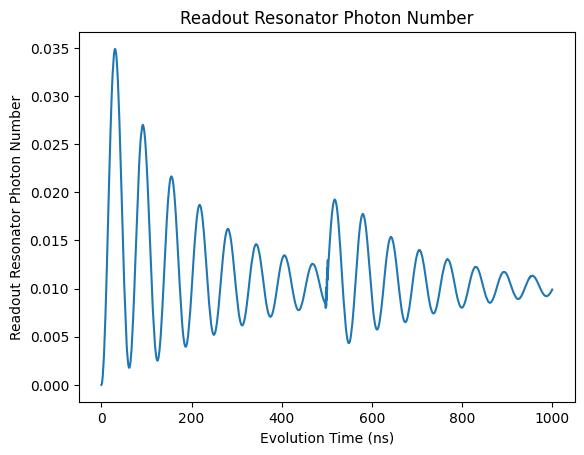

In [1279]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1280]:
maxphoton_simulation.append(np.max(result.expect[4][5000:]))

### $ \kappa = 2\pi 10MHz$

In [1281]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[1])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.010  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

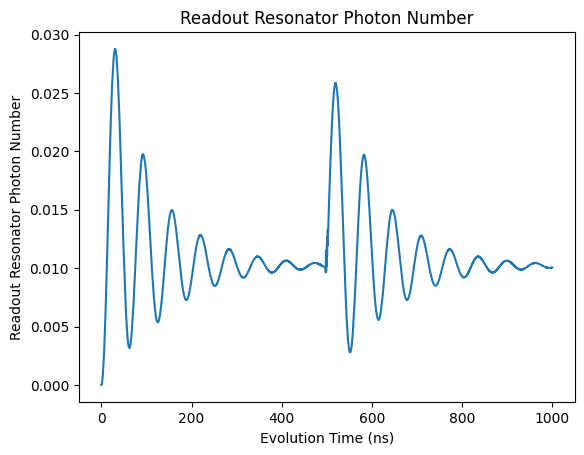

In [1282]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1283]:
maxphoton_simulation.append(np.max(result.expect[4][5000:]))

### $ \kappa = 2\pi 15MHz$

In [1284]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[2])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.015  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

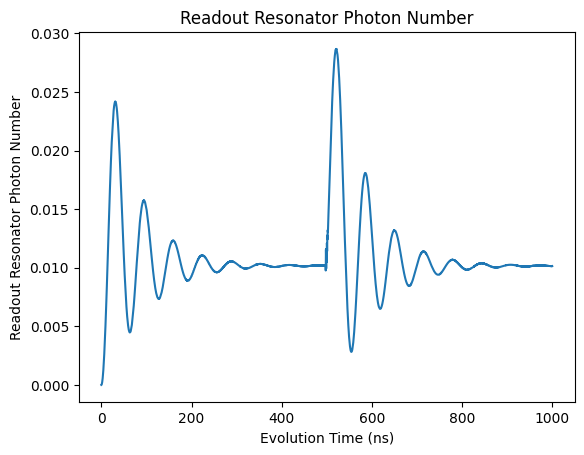

In [1285]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1286]:
maxphoton_simulation.append(np.max(result.expect[4][5000:]))

### $ \kappa = 2\pi 20MHz$

In [1287]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[3])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.020  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

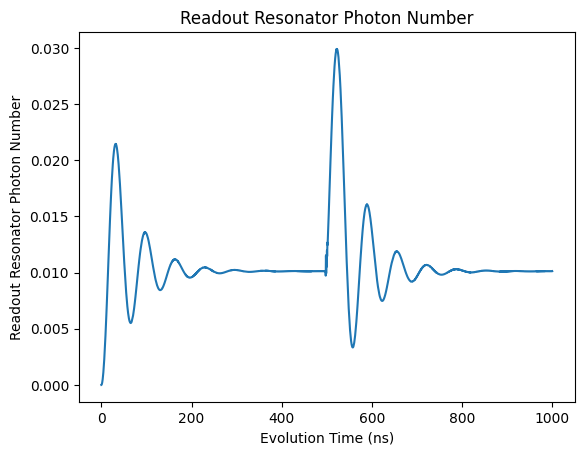

In [1288]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1289]:
maxphoton_simulation.append(np.max(result.expect[4][5000:]))

### $ \kappa = 2\pi 25MHz$

In [1290]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[4])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.025  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

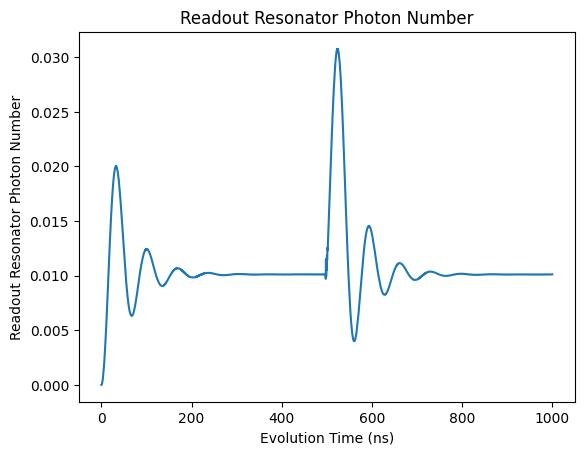

In [1291]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1292]:
maxphoton_simulation.append(np.max(result.expect[4][5000:]))

### $ \kappa = 2\pi 30MHz$

In [1293]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[5])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.030  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

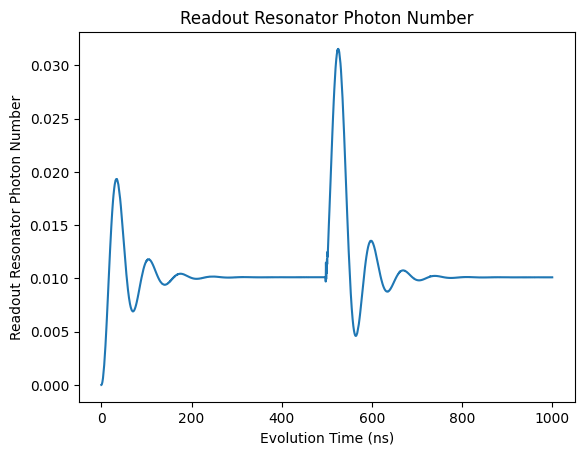

In [1294]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1295]:
maxphoton_simulation.append(np.max(result.expect[4][5000:]))

## $G=2\pi 20MHz$

In [1296]:
# readout resonator & purcell filter resonator dimension

N = 3


# constant

B = 0.1 * 2 * np.pi        # gate operation time : 50ns

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.020        # qubit-resonator coupling in units of GHz


detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi

# operator defined on bare basis

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_bare                 = tensor(sx, qeye(N), qeye(N))
sy_bare                 = tensor(sy, qeye(N), qeye(N))
sz_bare                 = tensor(sz, qeye(N), qeye(N))
sp_bare                 = tensor(sp, qeye(N), qeye(N))
sm_bare                 = tensor(sm, qeye(N), qeye(N))

readout_annihilate_bare = tensor(qeye(2), a, qeye(N))
readout_create_bare     = tensor(qeye(2), a.dag(), qeye(N))
readout_number_bare     = tensor(qeye(2), a.dag()*a, qeye(N))

filter_annihilate_bare  = tensor(qeye(2), qeye(N), b)
filter_create_bare      = tensor(qeye(2), qeye(N), b.dag())
filter_number_bare      = tensor(qeye(2), qeye(N), b.dag()*b)

psi0_bare               = tensor(basis(2,0), basis(N,0), basis(N,0))
psis_bare               = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi1_bare               = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_bare + omega_r*readout_number_bare + omega_f*filter_number_bare + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_bare

In [1297]:
sx_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ (-1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ (-1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + (-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ (-1j)*H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + (-1j)*H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ (-1j)*H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ (+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + (+1j)*H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ (+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + (+1j)*H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ (+1j)*H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + (+1j)*H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ (+1j)*H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
- H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() - H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
- H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() - H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
- H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()


sp_dressed = H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


readout_number_dressed = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 2*H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
+ 2*H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + 2*H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag() \


filter_number_dressed = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 2*H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() \
+ 2*H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + 2*H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()

In [1298]:
psi0_dressed             = H0.eigenstates()[1][0]
psi1_dressed             = H0.eigenstates()[1][1]
psis_dressed             = (psi0_dressed + psi1_dressed)/np.sqrt(2)

op_list = [sx_dressed, sy_dressed, sz_dressed, sp_dressed, readout_number_dressed, filter_number_dressed]

### $ \kappa = 2\pi 5MHz$

In [1299]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[6])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.005  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

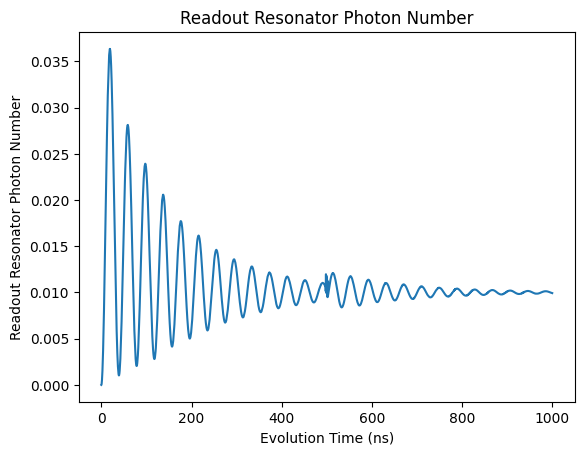

In [1300]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1301]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 10MHz$

In [1302]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[7])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.010  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

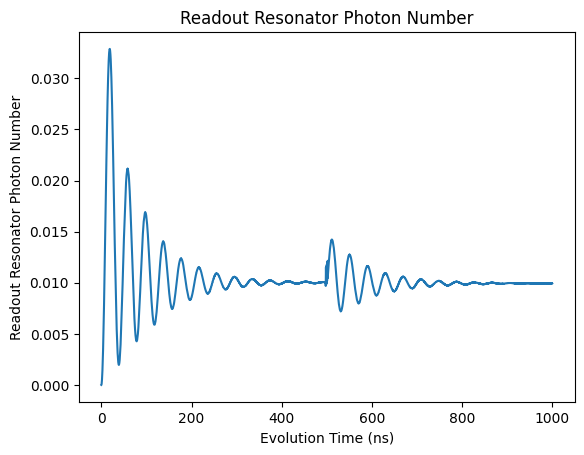

In [1303]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1304]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 15MHz$

In [1305]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[8])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.015  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

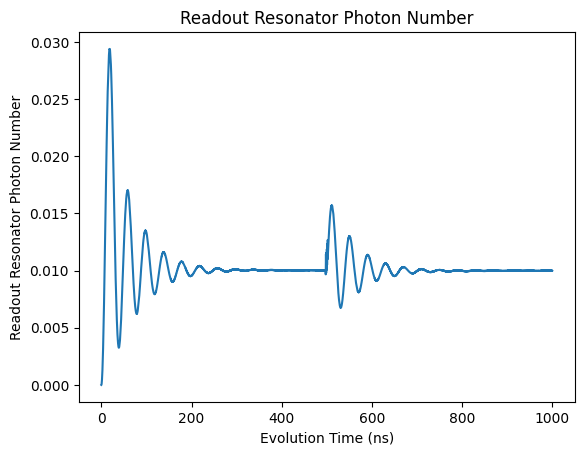

In [1306]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1307]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 20MHz$

In [1308]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[9])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.020  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

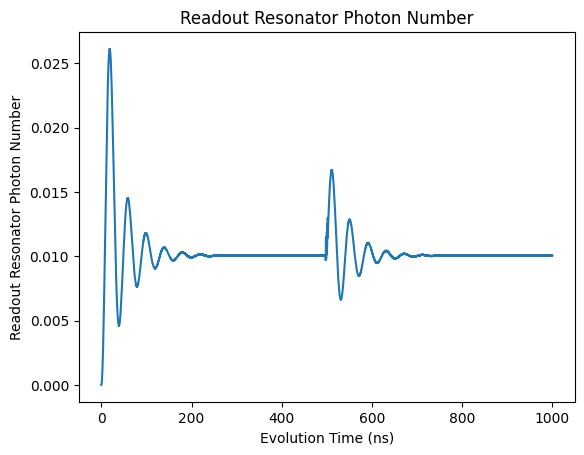

In [1309]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1310]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 25MHz$

In [1311]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[10])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.025  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

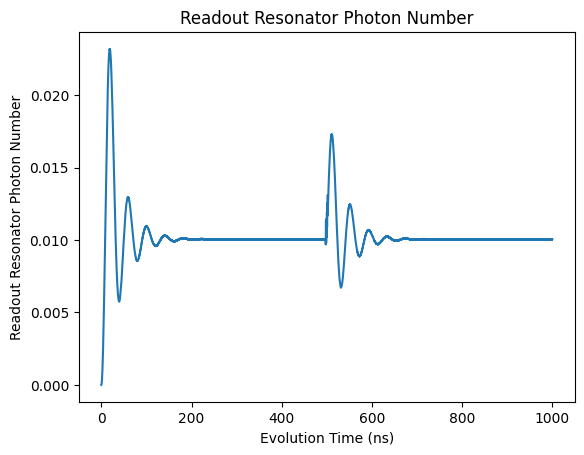

In [1312]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1313]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 30MHz$

In [1314]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[11])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.030  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

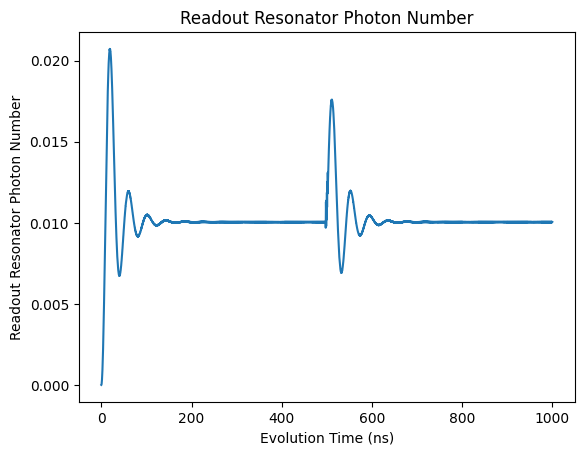

In [1315]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1316]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

## $G=2\pi 30MHz$

In [1317]:
# readout resonator & purcell filter resonator dimension

N = 3


# constant

B = 0.1 * 2 * np.pi        # gate operation time : 50ns

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.030        # qubit-resonator coupling in units of GHz


detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi

# operator defined on bare basis

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_bare                 = tensor(sx, qeye(N), qeye(N))
sy_bare                 = tensor(sy, qeye(N), qeye(N))
sz_bare                 = tensor(sz, qeye(N), qeye(N))
sp_bare                 = tensor(sp, qeye(N), qeye(N))
sm_bare                 = tensor(sm, qeye(N), qeye(N))

readout_annihilate_bare = tensor(qeye(2), a, qeye(N))
readout_create_bare     = tensor(qeye(2), a.dag(), qeye(N))
readout_number_bare     = tensor(qeye(2), a.dag()*a, qeye(N))

filter_annihilate_bare  = tensor(qeye(2), qeye(N), b)
filter_create_bare      = tensor(qeye(2), qeye(N), b.dag())
filter_number_bare      = tensor(qeye(2), qeye(N), b.dag()*b)

psi0_bare               = tensor(basis(2,0), basis(N,0), basis(N,0))
psis_bare               = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi1_bare               = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_bare + omega_r*readout_number_bare + omega_f*filter_number_bare + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_bare

In [1318]:
sx_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ (-1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ (-1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + (-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ (-1j)*H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + (-1j)*H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ (-1j)*H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ (+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + (+1j)*H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ (+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + (+1j)*H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ (+1j)*H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + (+1j)*H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ (+1j)*H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
- H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() - H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
- H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() - H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
- H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()


sp_dressed = H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


readout_number_dressed = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 2*H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
+ 2*H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + 2*H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag() \


filter_number_dressed = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 2*H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() \
+ 2*H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + 2*H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()

In [1319]:
psi0_dressed             = H0.eigenstates()[1][0]
psi1_dressed             = H0.eigenstates()[1][1]
psis_dressed             = (psi0_dressed + psi1_dressed)/np.sqrt(2)

op_list = [sx_dressed, sy_dressed, sz_dressed, sp_dressed, readout_number_dressed, filter_number_dressed]

### $ \kappa = 2\pi 5MHz$

In [1320]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[12])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.005  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

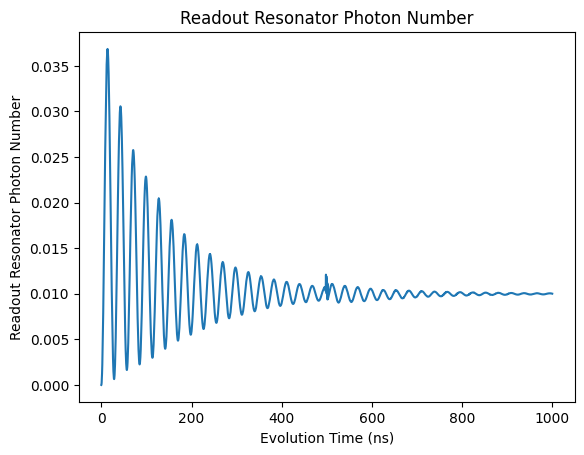

In [1321]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1322]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 10MHz$

In [1323]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[13])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.010  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

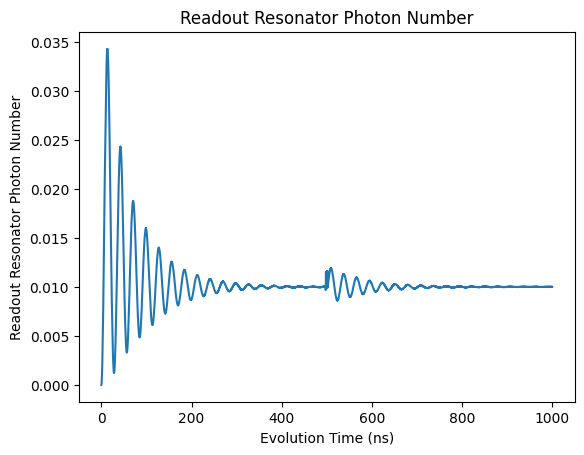

In [1324]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1325]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 15MHz$

In [1326]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[14])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.015  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

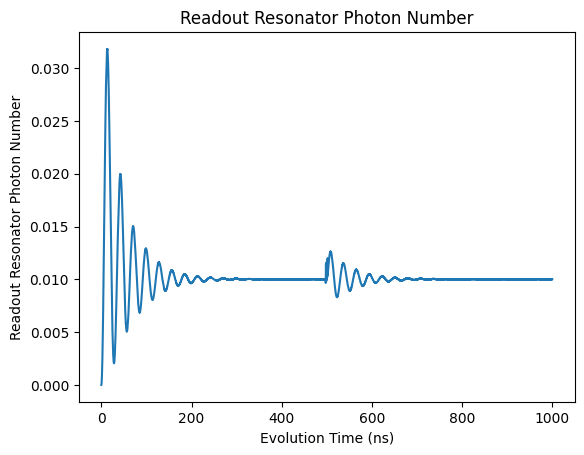

In [1327]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1328]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 20MHz$

In [1329]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[15])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.020  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

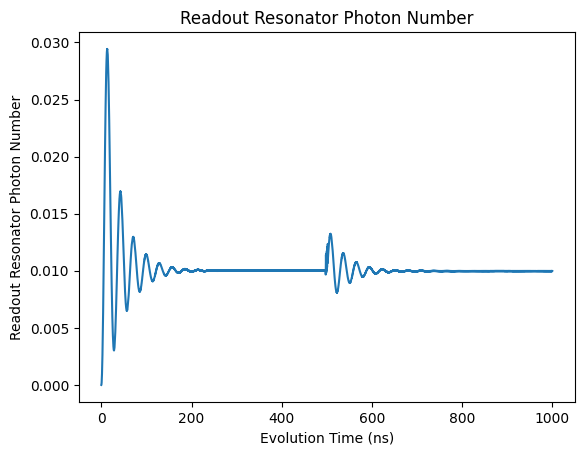

In [1330]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1331]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 25MHz$

In [1332]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[16])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.025  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

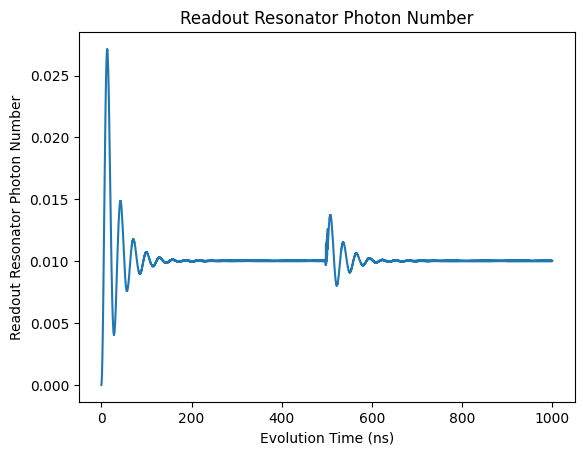

In [1333]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1334]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 30MHz$

In [1335]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[17])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.030  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

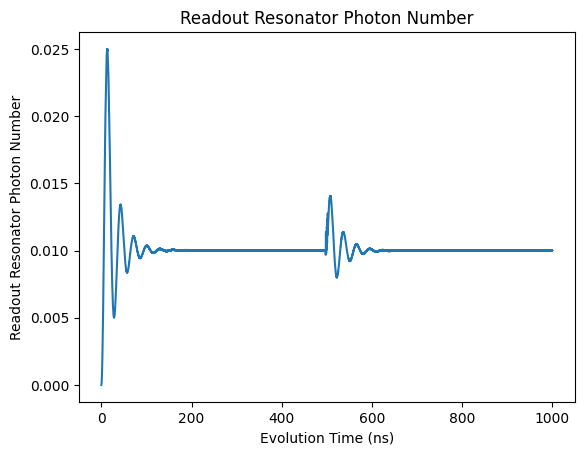

In [1336]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1337]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

## $G=2\pi 40MHz$

In [1338]:
# readout resonator & purcell filter resonator dimension

N = 3


# constant

B = 0.1 * 2 * np.pi        # gate operation time : 50ns

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.040        # qubit-resonator coupling in units of GHz


detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi

# operator defined on bare basis

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_bare                 = tensor(sx, qeye(N), qeye(N))
sy_bare                 = tensor(sy, qeye(N), qeye(N))
sz_bare                 = tensor(sz, qeye(N), qeye(N))
sp_bare                 = tensor(sp, qeye(N), qeye(N))
sm_bare                 = tensor(sm, qeye(N), qeye(N))

readout_annihilate_bare = tensor(qeye(2), a, qeye(N))
readout_create_bare     = tensor(qeye(2), a.dag(), qeye(N))
readout_number_bare     = tensor(qeye(2), a.dag()*a, qeye(N))

filter_annihilate_bare  = tensor(qeye(2), qeye(N), b)
filter_create_bare      = tensor(qeye(2), qeye(N), b.dag())
filter_number_bare      = tensor(qeye(2), qeye(N), b.dag()*b)

psi0_bare               = tensor(basis(2,0), basis(N,0), basis(N,0))
psis_bare               = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi1_bare               = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_bare + omega_r*readout_number_bare + omega_f*filter_number_bare + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_bare

In [1339]:
sx_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ (-1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ (-1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + (-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ (-1j)*H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + (-1j)*H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ (-1j)*H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ (+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + (+1j)*H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ (+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + (+1j)*H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ (+1j)*H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + (+1j)*H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ (+1j)*H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
- H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() - H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
- H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() - H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
- H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()


sp_dressed = H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


readout_number_dressed = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 2*H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
+ 2*H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + 2*H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag() \


filter_number_dressed = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 2*H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() \
+ 2*H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + 2*H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()

In [1340]:
psi0_dressed             = H0.eigenstates()[1][0]
psi1_dressed             = H0.eigenstates()[1][1]
psis_dressed             = (psi0_dressed + psi1_dressed)/np.sqrt(2)

op_list = [sx_dressed, sy_dressed, sz_dressed, sp_dressed, readout_number_dressed, filter_number_dressed]

### $ \kappa = 2\pi 5MHz$

In [1341]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[18])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.005  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

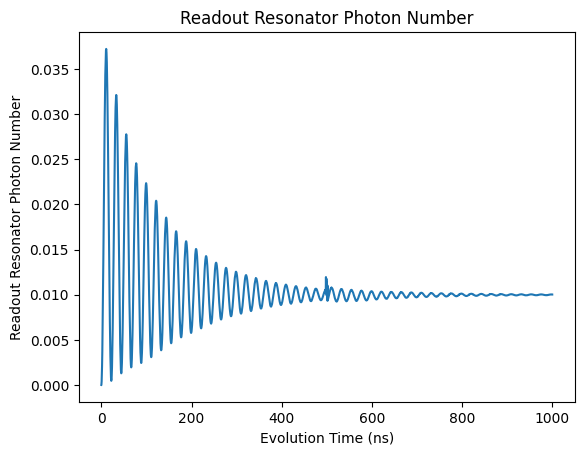

In [1342]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1343]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 10MHz$

In [1344]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[19])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.010  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

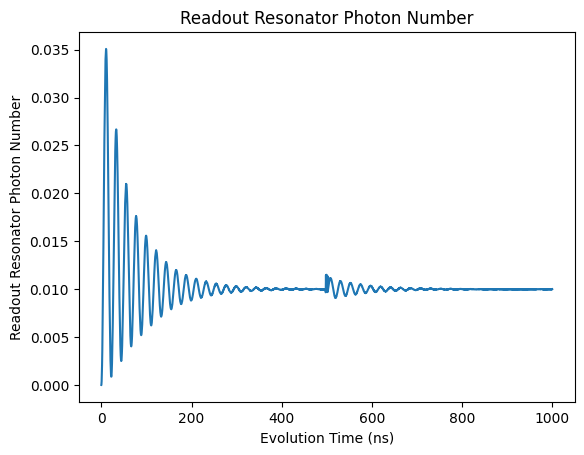

In [1345]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1346]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 15MHz$

In [1347]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[20])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.015  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

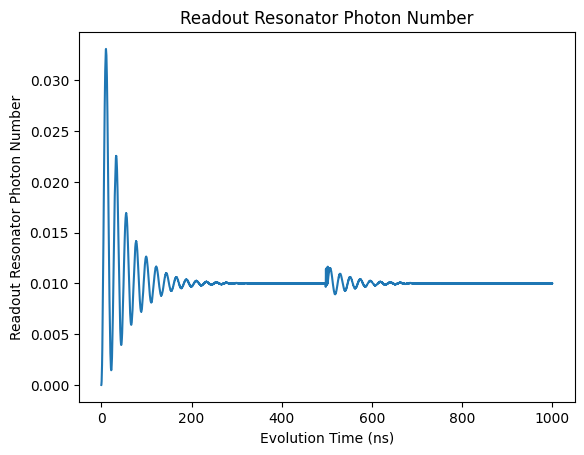

In [1348]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1349]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 20MHz$

In [1350]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[21])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.020  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

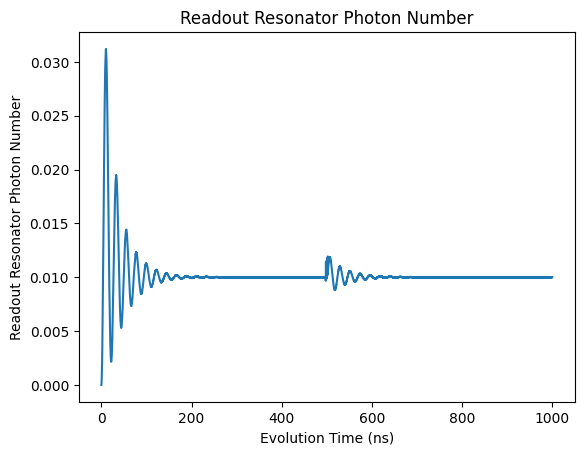

In [1351]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1352]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 25MHz$

In [1353]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[22])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.025  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

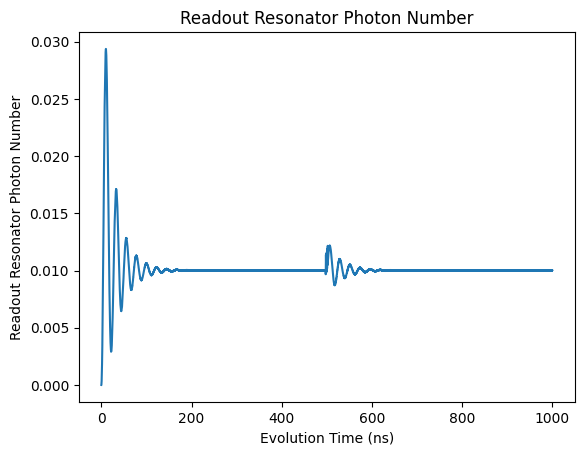

In [1354]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1355]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 30MHz$

In [1356]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[23])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.030  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

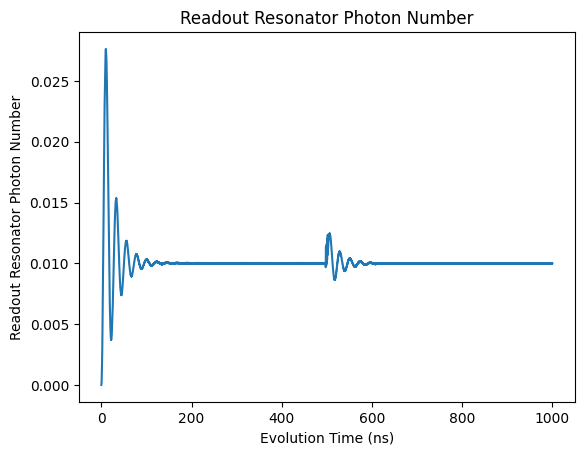

In [1357]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1358]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

## $G=2\pi 50MHz$

In [1359]:
# readout resonator & purcell filter resonator dimension

N = 3


# constant

B = 0.1 * 2 * np.pi        # gate operation time : 50ns

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.050        # qubit-resonator coupling in units of GHz


detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi

# operator defined on bare basis

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_bare                 = tensor(sx, qeye(N), qeye(N))
sy_bare                 = tensor(sy, qeye(N), qeye(N))
sz_bare                 = tensor(sz, qeye(N), qeye(N))
sp_bare                 = tensor(sp, qeye(N), qeye(N))
sm_bare                 = tensor(sm, qeye(N), qeye(N))

readout_annihilate_bare = tensor(qeye(2), a, qeye(N))
readout_create_bare     = tensor(qeye(2), a.dag(), qeye(N))
readout_number_bare     = tensor(qeye(2), a.dag()*a, qeye(N))

filter_annihilate_bare  = tensor(qeye(2), qeye(N), b)
filter_create_bare      = tensor(qeye(2), qeye(N), b.dag())
filter_number_bare      = tensor(qeye(2), qeye(N), b.dag()*b)

psi0_bare               = tensor(basis(2,0), basis(N,0), basis(N,0))
psis_bare               = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi1_bare               = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_bare + omega_r*readout_number_bare + omega_f*filter_number_bare + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_bare

In [1360]:
sx_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ (-1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ (-1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + (-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ (-1j)*H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + (-1j)*H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ (-1j)*H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ (+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + (+1j)*H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ (+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + (+1j)*H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ (+1j)*H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + (+1j)*H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ (+1j)*H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
- H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() - H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
- H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() - H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
- H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()


sp_dressed = H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


readout_number_dressed = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 2*H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
+ 2*H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + 2*H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag() \


filter_number_dressed = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 2*H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() \
+ 2*H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + 2*H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()

In [1361]:
psi0_dressed             = H0.eigenstates()[1][0]
psi1_dressed             = H0.eigenstates()[1][1]
psis_dressed             = (psi0_dressed + psi1_dressed)/np.sqrt(2)

op_list = [sx_dressed, sy_dressed, sz_dressed, sp_dressed, readout_number_dressed, filter_number_dressed]

### $ \kappa = 2\pi 5MHz$

In [1362]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[24])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.005  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

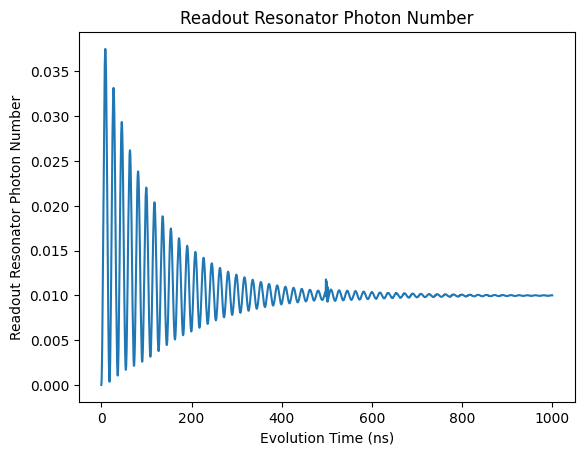

In [1363]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1364]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 10MHz$

In [1365]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[25])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.010  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

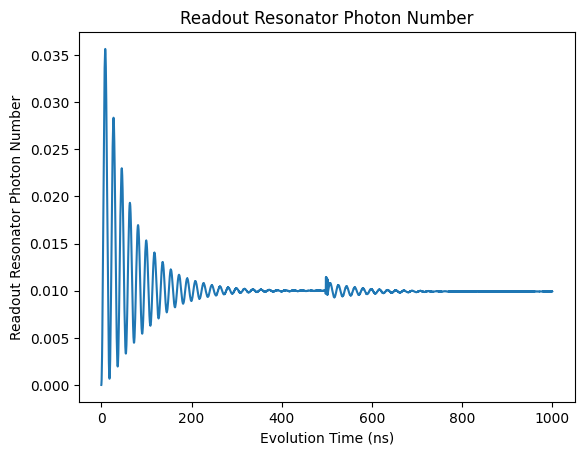

In [1366]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1367]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 15MHz$

In [1368]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[26])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.015  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

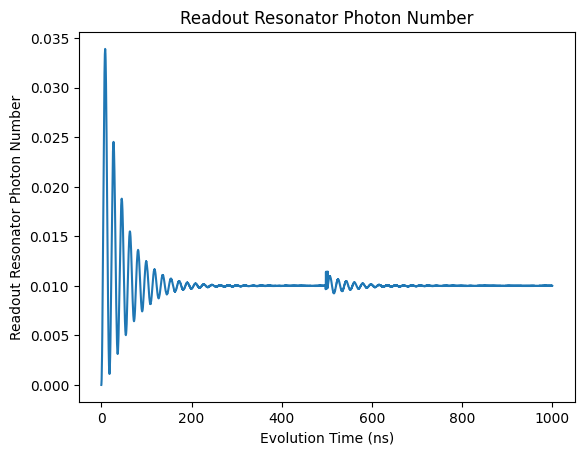

In [1369]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1370]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 20MHz$

In [1371]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[27])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.020  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

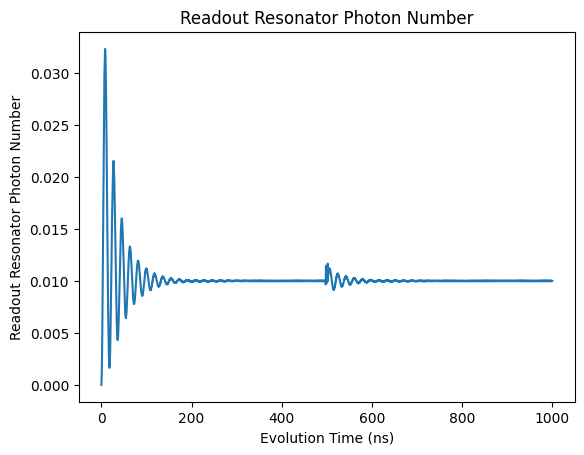

In [1372]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1373]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 25MHz$

In [1374]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[28])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.025  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

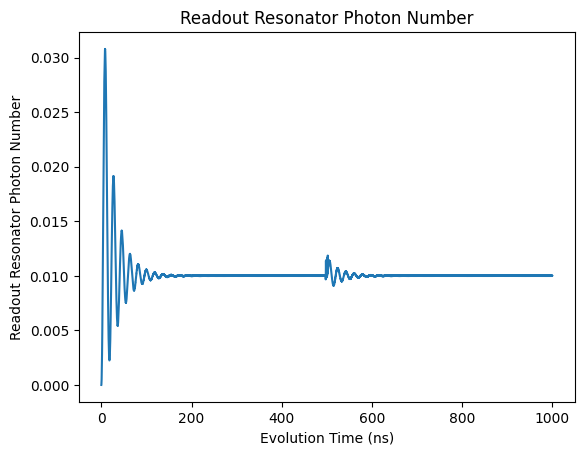

In [1375]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1376]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 30MHz$

In [1377]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[29])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.030  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

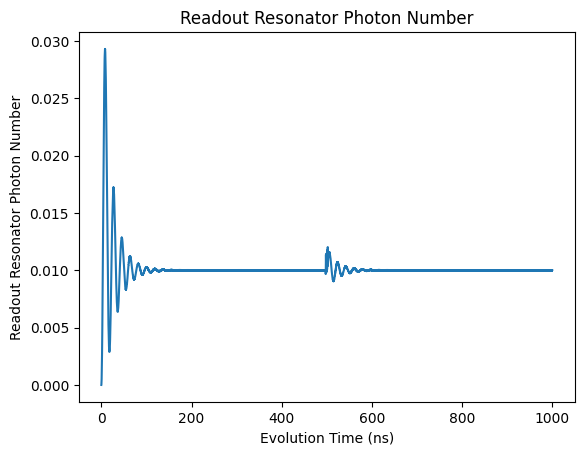

In [1378]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1379]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

## $G=2\pi 60MHz$

In [1380]:
# readout resonator & purcell filter resonator dimension

N = 3


# constant

B = 0.1 * 2 * np.pi        # gate operation time : 50ns

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.060        # qubit-resonator coupling in units of GHz


detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi

# operator defined on bare basis

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_bare                 = tensor(sx, qeye(N), qeye(N))
sy_bare                 = tensor(sy, qeye(N), qeye(N))
sz_bare                 = tensor(sz, qeye(N), qeye(N))
sp_bare                 = tensor(sp, qeye(N), qeye(N))
sm_bare                 = tensor(sm, qeye(N), qeye(N))

readout_annihilate_bare = tensor(qeye(2), a, qeye(N))
readout_create_bare     = tensor(qeye(2), a.dag(), qeye(N))
readout_number_bare     = tensor(qeye(2), a.dag()*a, qeye(N))

filter_annihilate_bare  = tensor(qeye(2), qeye(N), b)
filter_create_bare      = tensor(qeye(2), qeye(N), b.dag())
filter_number_bare      = tensor(qeye(2), qeye(N), b.dag()*b)

psi0_bare               = tensor(basis(2,0), basis(N,0), basis(N,0))
psis_bare               = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi1_bare               = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_bare + omega_r*readout_number_bare + omega_f*filter_number_bare + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_bare

In [1381]:
sx_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ (-1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ (-1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + (-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ (-1j)*H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + (-1j)*H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ (-1j)*H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ (+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + (+1j)*H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ (+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + (+1j)*H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ (+1j)*H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + (+1j)*H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ (+1j)*H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
- H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() - H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
- H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() - H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
- H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()


sp_dressed = H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


readout_number_dressed = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 2*H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
+ 2*H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + 2*H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag() \


filter_number_dressed = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 2*H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() \
+ 2*H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + 2*H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()

In [1382]:
psi0_dressed             = H0.eigenstates()[1][0]
psi1_dressed             = H0.eigenstates()[1][1]
psis_dressed             = (psi0_dressed + psi1_dressed)/np.sqrt(2)

op_list = [sx_dressed, sy_dressed, sz_dressed, sp_dressed, readout_number_dressed, filter_number_dressed]

### $ \kappa = 2\pi 5MHz$

In [1383]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[30])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.005  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

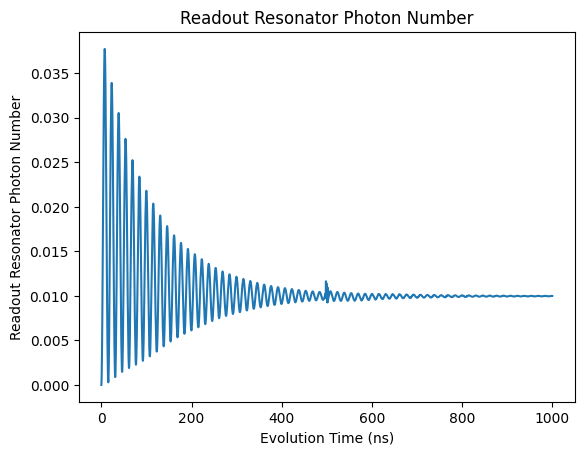

In [1384]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1385]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 10MHz$

In [1386]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[31])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.010  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

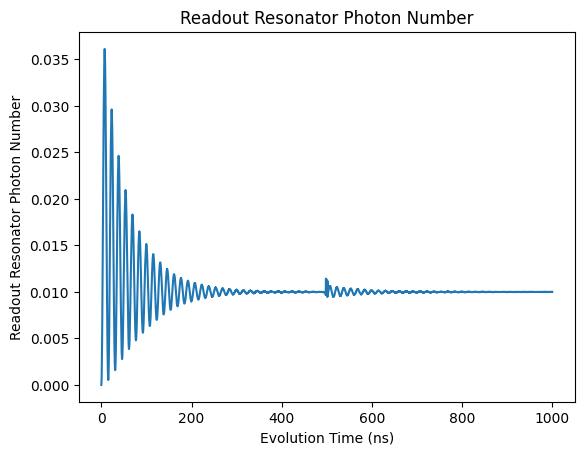

In [1387]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1388]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 15MHz$

In [1389]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[32])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.015  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

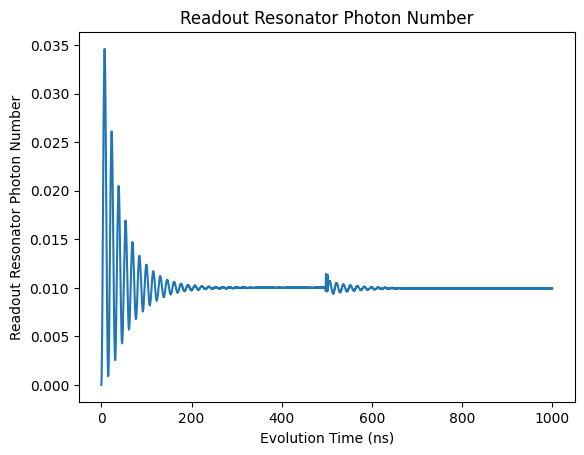

In [1390]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1391]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 20MHz$

In [1392]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[33])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.020  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

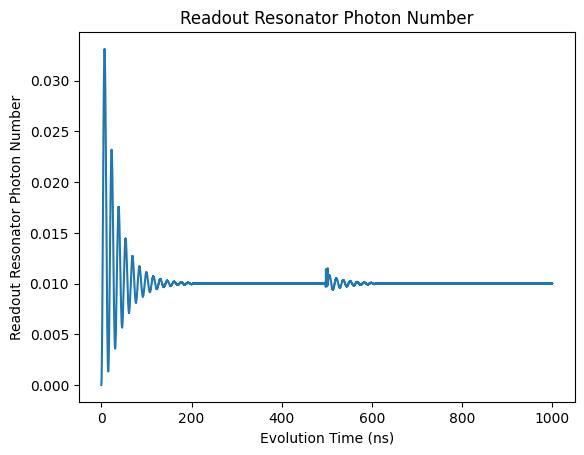

In [1393]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1394]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 25MHz$

In [1395]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[34])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.025  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

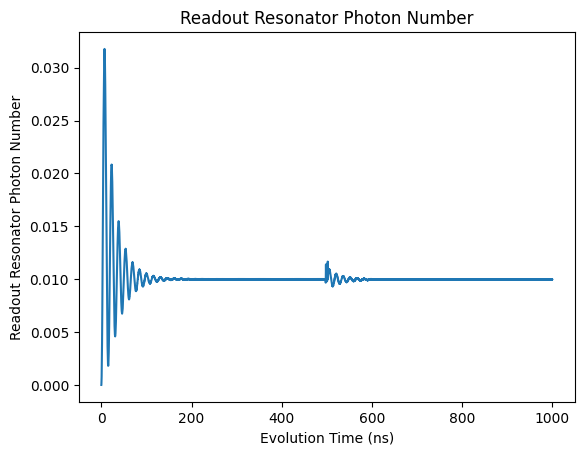

In [1396]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1397]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 30MHz$

In [1398]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.01/rphoton_standard[35])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.030  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

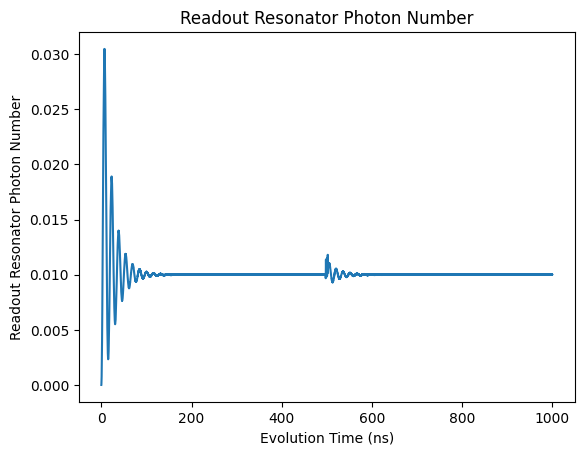

In [1399]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1400]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

## Excitation

In [1401]:
maxphoton_simulation = np.array(maxphoton_simulation)

print(maxphoton_simulation)

[0.01923814 0.02585411 0.02867514 0.0299236  0.03075525 0.03153985
 0.01209427 0.01421035 0.01570716 0.01670729 0.01729316 0.01759589
 0.01107862 0.01190648 0.01262932 0.01323826 0.01372942 0.01407875
 0.0107848  0.01114352 0.01150762 0.01185806 0.01218312 0.01245363
 0.0106481  0.01081885 0.01099044 0.01118786 0.01138304 0.01156155
 0.01051925 0.01063586 0.01070407 0.01081049 0.01089759 0.01098411]


[0.00048563759834318687, 0.0007367610908625486, 0.0009676363831588821, 0.0011482052008114406, 0.0012921614639376181, 0.0014097259274097995, 0.0001854497981901584, 0.0001782465463900859, 0.00018436708173946018, 0.00019781644758925593, 0.00021734177067239124, 0.00024024985796919232, 0.0001221443728977394, 0.00011125496346296406, 0.00010383927540125643, 0.00010010385696077287, 9.836618224344492e-05, 9.862122165536087e-05, 8.955298163290227e-05, 8.178619002695915e-05, 7.562470800087987e-05, 7.107166183305637e-05, 6.707318956155272e-05, 6.438483629696457e-05, 6.685563563985153e-05, 6.220482955363911e-05, 5.7485811533976774e-05, 5.38819733213249e-05, 5.085387524498953e-05, 4.830090984480068e-05, 4.902544778293346e-05, 4.605128766146841e-05, 4.333498315989108e-05, 4.083053692329936e-05, 3.86921813271328e-05, 3.684828839064534e-05]

# Photon Excitation during $\pi$ pulse

$n=0.001$

In [1402]:
rphoton_standard = np.array([1.91285228e-04, 2.29768015e-04, 2.75803820e-04, 3.16988427e-04,
 3.49525879e-04, 3.74277884e-04, 6.09307246e-05, 6.47143029e-05,
 7.07765667e-05, 7.89283251e-05, 8.88838246e-05, 1.00268464e-04,
 2.94368297e-05, 3.02068221e-05, 3.14801210e-05, 3.32407649e-05,
 3.54801193e-05, 3.81839996e-05, 1.72745529e-05, 1.75079141e-05,
 1.79124535e-05, 1.84761796e-05, 1.91981487e-05, 2.00772725e-05,
 1.13439865e-05, 1.14291338e-05, 1.15932517e-05, 1.18237122e-05,
 1.21198487e-05, 1.24813912e-05, 8.01689854e-06, 8.04869496e-06,
 8.12649680e-06, 8.23705417e-06, 8.37957899e-06, 8.55387835e-06,])

maxphoton_simulation = []

## $G=2\pi 10MHz$

In [1403]:
# readout resonator & purcell filter resonator dimension

N = 3


# constant

B = 0.1 * 2 * np.pi        # gate operation time : 50ns

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.010        # qubit-resonator coupling in units of GHz


detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi

# operator defined on bare basis

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_bare                 = tensor(sx, qeye(N), qeye(N))
sy_bare                 = tensor(sy, qeye(N), qeye(N))
sz_bare                 = tensor(sz, qeye(N), qeye(N))
sp_bare                 = tensor(sp, qeye(N), qeye(N))
sm_bare                 = tensor(sm, qeye(N), qeye(N))

readout_annihilate_bare = tensor(qeye(2), a, qeye(N))
readout_create_bare     = tensor(qeye(2), a.dag(), qeye(N))
readout_number_bare     = tensor(qeye(2), a.dag()*a, qeye(N))

filter_annihilate_bare  = tensor(qeye(2), qeye(N), b)
filter_create_bare      = tensor(qeye(2), qeye(N), b.dag())
filter_number_bare      = tensor(qeye(2), qeye(N), b.dag()*b)

psi0_bare               = tensor(basis(2,0), basis(N,0), basis(N,0))
psis_bare               = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi1_bare               = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_bare + omega_r*readout_number_bare + omega_f*filter_number_bare + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_bare

In [1404]:
sx_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ (-1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ (-1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + (-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ (-1j)*H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + (-1j)*H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ (-1j)*H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ (+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + (+1j)*H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ (+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + (+1j)*H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ (+1j)*H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + (+1j)*H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ (+1j)*H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
- H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() - H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
- H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() - H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
- H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()


sp_dressed = H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


readout_number_dressed = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 2*H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
+ 2*H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + 2*H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag() \


filter_number_dressed = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 2*H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() \
+ 2*H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + 2*H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()

In [1405]:
psi0_dressed             = H0.eigenstates()[1][0]
psi1_dressed             = H0.eigenstates()[1][1]
psis_dressed             = (psi0_dressed + psi1_dressed)/np.sqrt(2)

op_list = [sx_dressed, sy_dressed, sz_dressed, sp_dressed, readout_number_dressed, filter_number_dressed]

### $ \kappa = 2\pi 5MHz$

In [1406]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[0])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.005  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

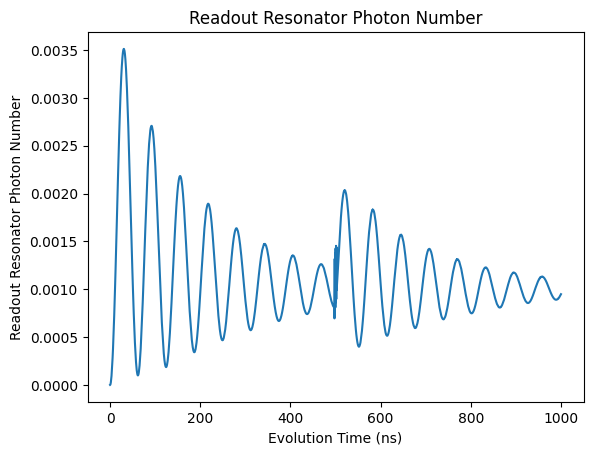

In [1407]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1408]:
maxphoton_simulation.append(np.max(result.expect[4][5000:]))

### $ \kappa = 2\pi 10MHz$

In [1409]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[1])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.010  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

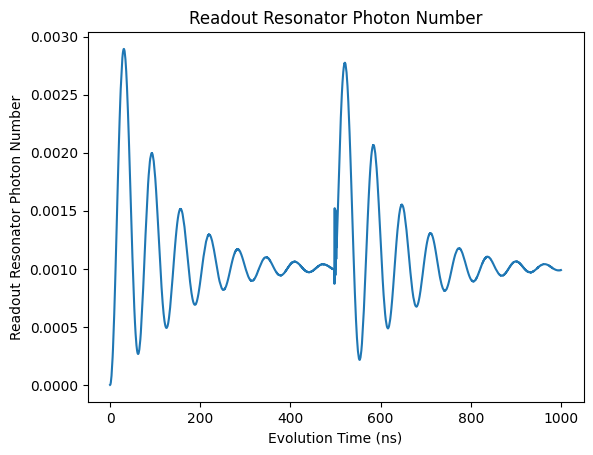

In [1410]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1411]:
maxphoton_simulation.append(np.max(result.expect[4][5000:]))

### $ \kappa = 2\pi 15MHz$

In [1412]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[2])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.015  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

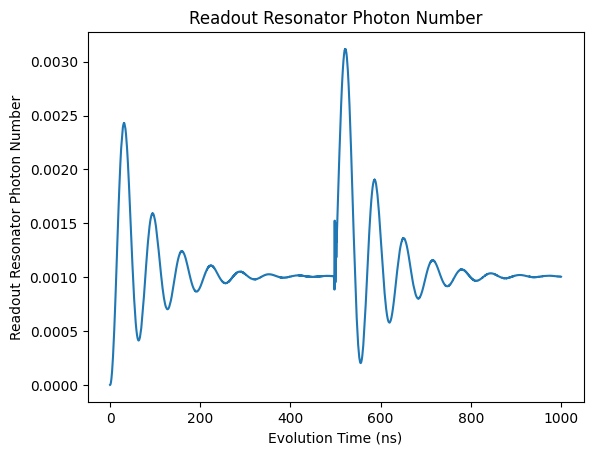

In [1413]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1414]:
maxphoton_simulation.append(np.max(result.expect[4][5000:]))

### $ \kappa = 2\pi 20MHz$

In [1415]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[3])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.020  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

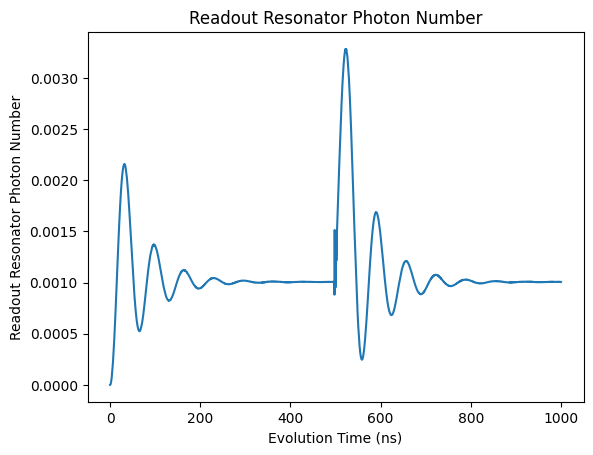

In [1416]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1417]:
maxphoton_simulation.append(np.max(result.expect[4][5000:]))

### $ \kappa = 2\pi 25MHz$

In [1418]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[4])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.025  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

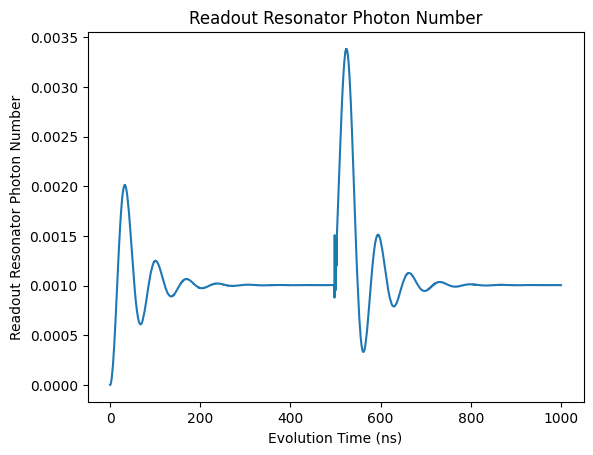

In [1419]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1420]:
maxphoton_simulation.append(np.max(result.expect[4][5000:]))

### $ \kappa = 2\pi 30MHz$

In [1421]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[5])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.030  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

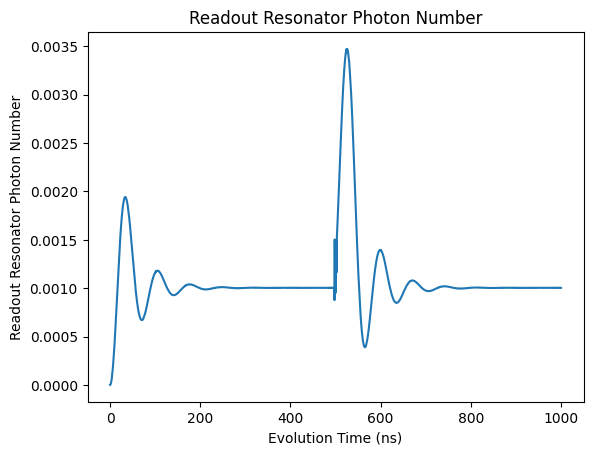

In [1422]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1423]:
maxphoton_simulation.append(np.max(result.expect[4][5000:]))

## $G=2\pi 20MHz$

In [1424]:
# readout resonator & purcell filter resonator dimension

N = 3


# constant

B = 0.1 * 2 * np.pi        # gate operation time : 50ns

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.020        # qubit-resonator coupling in units of GHz


detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi

# operator defined on bare basis

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_bare                 = tensor(sx, qeye(N), qeye(N))
sy_bare                 = tensor(sy, qeye(N), qeye(N))
sz_bare                 = tensor(sz, qeye(N), qeye(N))
sp_bare                 = tensor(sp, qeye(N), qeye(N))
sm_bare                 = tensor(sm, qeye(N), qeye(N))

readout_annihilate_bare = tensor(qeye(2), a, qeye(N))
readout_create_bare     = tensor(qeye(2), a.dag(), qeye(N))
readout_number_bare     = tensor(qeye(2), a.dag()*a, qeye(N))

filter_annihilate_bare  = tensor(qeye(2), qeye(N), b)
filter_create_bare      = tensor(qeye(2), qeye(N), b.dag())
filter_number_bare      = tensor(qeye(2), qeye(N), b.dag()*b)

psi0_bare               = tensor(basis(2,0), basis(N,0), basis(N,0))
psis_bare               = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi1_bare               = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_bare + omega_r*readout_number_bare + omega_f*filter_number_bare + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_bare

In [1425]:
sx_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ (-1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ (-1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + (-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ (-1j)*H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + (-1j)*H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ (-1j)*H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ (+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + (+1j)*H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ (+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + (+1j)*H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ (+1j)*H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + (+1j)*H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ (+1j)*H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
- H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() - H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
- H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() - H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
- H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()


sp_dressed = H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


readout_number_dressed = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 2*H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
+ 2*H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + 2*H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag() \


filter_number_dressed = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 2*H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() \
+ 2*H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + 2*H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()

In [1426]:
psi0_dressed             = H0.eigenstates()[1][0]
psi1_dressed             = H0.eigenstates()[1][1]
psis_dressed             = (psi0_dressed + psi1_dressed)/np.sqrt(2)

op_list = [sx_dressed, sy_dressed, sz_dressed, sp_dressed, readout_number_dressed, filter_number_dressed]

### $ \kappa = 2\pi 5MHz$

In [1427]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[6])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.005  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

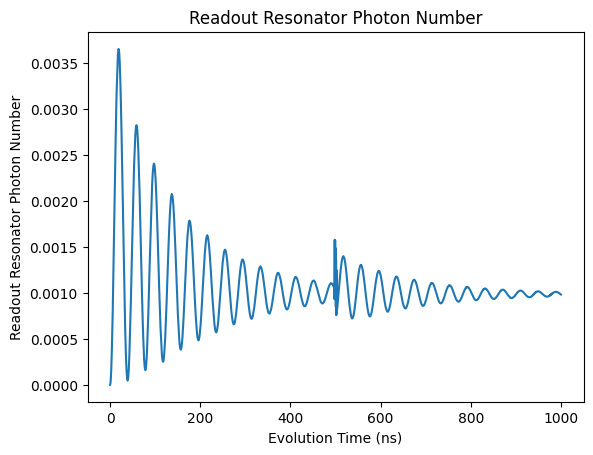

In [1428]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1429]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 10MHz$

In [1430]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[7])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.010  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

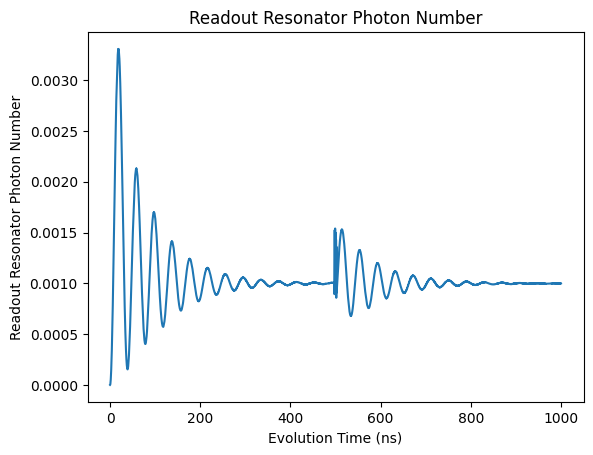

In [1431]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [1432]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 15MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[8])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.015  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 20MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[9])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.020  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 25MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[10])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.025  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 30MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[11])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.030  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

## $G=2\pi 30MHz$

In [ ]:
# readout resonator & purcell filter resonator dimension

N = 3


# constant

B = 0.1 * 2 * np.pi        # gate operation time : 50ns

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.030        # qubit-resonator coupling in units of GHz


detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi

# operator defined on bare basis

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_bare                 = tensor(sx, qeye(N), qeye(N))
sy_bare                 = tensor(sy, qeye(N), qeye(N))
sz_bare                 = tensor(sz, qeye(N), qeye(N))
sp_bare                 = tensor(sp, qeye(N), qeye(N))
sm_bare                 = tensor(sm, qeye(N), qeye(N))

readout_annihilate_bare = tensor(qeye(2), a, qeye(N))
readout_create_bare     = tensor(qeye(2), a.dag(), qeye(N))
readout_number_bare     = tensor(qeye(2), a.dag()*a, qeye(N))

filter_annihilate_bare  = tensor(qeye(2), qeye(N), b)
filter_create_bare      = tensor(qeye(2), qeye(N), b.dag())
filter_number_bare      = tensor(qeye(2), qeye(N), b.dag()*b)

psi0_bare               = tensor(basis(2,0), basis(N,0), basis(N,0))
psis_bare               = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi1_bare               = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_bare + omega_r*readout_number_bare + omega_f*filter_number_bare + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_bare

In [ ]:
sx_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ (-1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ (-1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + (-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ (-1j)*H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + (-1j)*H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ (-1j)*H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ (+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + (+1j)*H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ (+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + (+1j)*H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ (+1j)*H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + (+1j)*H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ (+1j)*H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
- H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() - H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
- H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() - H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
- H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()


sp_dressed = H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


readout_number_dressed = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 2*H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
+ 2*H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + 2*H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag() \


filter_number_dressed = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 2*H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() \
+ 2*H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + 2*H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()

In [ ]:
psi0_dressed             = H0.eigenstates()[1][0]
psi1_dressed             = H0.eigenstates()[1][1]
psis_dressed             = (psi0_dressed + psi1_dressed)/np.sqrt(2)

op_list = [sx_dressed, sy_dressed, sz_dressed, sp_dressed, readout_number_dressed, filter_number_dressed]

### $ \kappa = 2\pi 5MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[12])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.005  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 10MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[13])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.010  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 15MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[14])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.015  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 20MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[15])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.020  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 25MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[16])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.025  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 30MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[17])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.030  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

## $G=2\pi 40MHz$

In [ ]:
# readout resonator & purcell filter resonator dimension

N = 3


# constant

B = 0.1 * 2 * np.pi        # gate operation time : 50ns

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.040        # qubit-resonator coupling in units of GHz


detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi

# operator defined on bare basis

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_bare                 = tensor(sx, qeye(N), qeye(N))
sy_bare                 = tensor(sy, qeye(N), qeye(N))
sz_bare                 = tensor(sz, qeye(N), qeye(N))
sp_bare                 = tensor(sp, qeye(N), qeye(N))
sm_bare                 = tensor(sm, qeye(N), qeye(N))

readout_annihilate_bare = tensor(qeye(2), a, qeye(N))
readout_create_bare     = tensor(qeye(2), a.dag(), qeye(N))
readout_number_bare     = tensor(qeye(2), a.dag()*a, qeye(N))

filter_annihilate_bare  = tensor(qeye(2), qeye(N), b)
filter_create_bare      = tensor(qeye(2), qeye(N), b.dag())
filter_number_bare      = tensor(qeye(2), qeye(N), b.dag()*b)

psi0_bare               = tensor(basis(2,0), basis(N,0), basis(N,0))
psis_bare               = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi1_bare               = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_bare + omega_r*readout_number_bare + omega_f*filter_number_bare + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_bare

In [ ]:
sx_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ (-1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ (-1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + (-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ (-1j)*H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + (-1j)*H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ (-1j)*H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ (+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + (+1j)*H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ (+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + (+1j)*H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ (+1j)*H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + (+1j)*H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ (+1j)*H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
- H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() - H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
- H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() - H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
- H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()


sp_dressed = H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


readout_number_dressed = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 2*H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
+ 2*H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + 2*H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag() \


filter_number_dressed = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 2*H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() \
+ 2*H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + 2*H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()

In [ ]:
psi0_dressed             = H0.eigenstates()[1][0]
psi1_dressed             = H0.eigenstates()[1][1]
psis_dressed             = (psi0_dressed + psi1_dressed)/np.sqrt(2)

op_list = [sx_dressed, sy_dressed, sz_dressed, sp_dressed, readout_number_dressed, filter_number_dressed]

### $ \kappa = 2\pi 5MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[18])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.005  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 10MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[19])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.010  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 15MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[20])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.015  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 20MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[21])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.020  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 25MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[22])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.025  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 30MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[23])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.030  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

## $G=2\pi 50MHz$

In [ ]:
# readout resonator & purcell filter resonator dimension

N = 3


# constant

B = 0.1 * 2 * np.pi        # gate operation time : 50ns

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.050        # qubit-resonator coupling in units of GHz


detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi

# operator defined on bare basis

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_bare                 = tensor(sx, qeye(N), qeye(N))
sy_bare                 = tensor(sy, qeye(N), qeye(N))
sz_bare                 = tensor(sz, qeye(N), qeye(N))
sp_bare                 = tensor(sp, qeye(N), qeye(N))
sm_bare                 = tensor(sm, qeye(N), qeye(N))

readout_annihilate_bare = tensor(qeye(2), a, qeye(N))
readout_create_bare     = tensor(qeye(2), a.dag(), qeye(N))
readout_number_bare     = tensor(qeye(2), a.dag()*a, qeye(N))

filter_annihilate_bare  = tensor(qeye(2), qeye(N), b)
filter_create_bare      = tensor(qeye(2), qeye(N), b.dag())
filter_number_bare      = tensor(qeye(2), qeye(N), b.dag()*b)

psi0_bare               = tensor(basis(2,0), basis(N,0), basis(N,0))
psis_bare               = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi1_bare               = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_bare + omega_r*readout_number_bare + omega_f*filter_number_bare + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_bare

In [ ]:
sx_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ (-1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ (-1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + (-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ (-1j)*H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + (-1j)*H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ (-1j)*H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ (+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + (+1j)*H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ (+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + (+1j)*H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ (+1j)*H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + (+1j)*H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ (+1j)*H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
- H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() - H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
- H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() - H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
- H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()


sp_dressed = H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


readout_number_dressed = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 2*H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
+ 2*H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + 2*H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag() \


filter_number_dressed = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 2*H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() \
+ 2*H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + 2*H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()

In [ ]:
psi0_dressed             = H0.eigenstates()[1][0]
psi1_dressed             = H0.eigenstates()[1][1]
psis_dressed             = (psi0_dressed + psi1_dressed)/np.sqrt(2)

op_list = [sx_dressed, sy_dressed, sz_dressed, sp_dressed, readout_number_dressed, filter_number_dressed]

### $ \kappa = 2\pi 5MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[24])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.005  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 10MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[25])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.010  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 15MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[26])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.015  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 20MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[27])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.020  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 25MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[28])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.025  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 30MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[29])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.030  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

## $G=2\pi 60MHz$

In [ ]:
# readout resonator & purcell filter resonator dimension

N = 3


# constant

B = 0.1 * 2 * np.pi        # gate operation time : 50ns

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.060        # qubit-resonator coupling in units of GHz


detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi

# operator defined on bare basis

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_bare                 = tensor(sx, qeye(N), qeye(N))
sy_bare                 = tensor(sy, qeye(N), qeye(N))
sz_bare                 = tensor(sz, qeye(N), qeye(N))
sp_bare                 = tensor(sp, qeye(N), qeye(N))
sm_bare                 = tensor(sm, qeye(N), qeye(N))

readout_annihilate_bare = tensor(qeye(2), a, qeye(N))
readout_create_bare     = tensor(qeye(2), a.dag(), qeye(N))
readout_number_bare     = tensor(qeye(2), a.dag()*a, qeye(N))

filter_annihilate_bare  = tensor(qeye(2), qeye(N), b)
filter_create_bare      = tensor(qeye(2), qeye(N), b.dag())
filter_number_bare      = tensor(qeye(2), qeye(N), b.dag()*b)

psi0_bare               = tensor(basis(2,0), basis(N,0), basis(N,0))
psis_bare               = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi1_bare               = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_bare + omega_r*readout_number_bare + omega_f*filter_number_bare + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_bare

In [ ]:
sx_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ (-1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ (-1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + (-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ (-1j)*H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + (-1j)*H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ (-1j)*H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ (+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + (+1j)*H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ (+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + (+1j)*H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ (+1j)*H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + (+1j)*H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ (+1j)*H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
- H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() - H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
- H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() - H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
- H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()


sp_dressed = H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


readout_number_dressed = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 2*H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
+ 2*H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + 2*H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag() \


filter_number_dressed = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 2*H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() \
+ 2*H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + 2*H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()

In [ ]:
psi0_dressed             = H0.eigenstates()[1][0]
psi1_dressed             = H0.eigenstates()[1][1]
psis_dressed             = (psi0_dressed + psi1_dressed)/np.sqrt(2)

op_list = [sx_dressed, sy_dressed, sz_dressed, sp_dressed, readout_number_dressed, filter_number_dressed]

### $ \kappa = 2\pi 5MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[30])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.005  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 10MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[31])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.010  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 15MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[32])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.015  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 20MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[33])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.020  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 25MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[34])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.025  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 30MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.001/rphoton_standard[35])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.030  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

## Excitation

In [ ]:
maxphoton_simulation = np.array(maxphoton_simulation)

print(maxphoton_simulation)

# Photon Excitation during $\pi$ pulse

$n=0.0001$

In [ ]:
rphoton_standard = np.array([1.91285228e-04, 2.29768015e-04, 2.75803820e-04, 3.16988427e-04,
 3.49525879e-04, 3.74277884e-04, 6.09307246e-05, 6.47143029e-05,
 7.07765667e-05, 7.89283251e-05, 8.88838246e-05, 1.00268464e-04,
 2.94368297e-05, 3.02068221e-05, 3.14801210e-05, 3.32407649e-05,
 3.54801193e-05, 3.81839996e-05, 1.72745529e-05, 1.75079141e-05,
 1.79124535e-05, 1.84761796e-05, 1.91981487e-05, 2.00772725e-05,
 1.13439865e-05, 1.14291338e-05, 1.15932517e-05, 1.18237122e-05,
 1.21198487e-05, 1.24813912e-05, 8.01689854e-06, 8.04869496e-06,
 8.12649680e-06, 8.23705417e-06, 8.37957899e-06, 8.55387835e-06,])

maxphoton_simulation = []

## $G=2\pi 10MHz$

In [ ]:
# readout resonator & purcell filter resonator dimension

N = 3


# constant

B = 0.1 * 2 * np.pi        # gate operation time : 50ns

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.010        # qubit-resonator coupling in units of GHz


detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi

# operator defined on bare basis

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_bare                 = tensor(sx, qeye(N), qeye(N))
sy_bare                 = tensor(sy, qeye(N), qeye(N))
sz_bare                 = tensor(sz, qeye(N), qeye(N))
sp_bare                 = tensor(sp, qeye(N), qeye(N))
sm_bare                 = tensor(sm, qeye(N), qeye(N))

readout_annihilate_bare = tensor(qeye(2), a, qeye(N))
readout_create_bare     = tensor(qeye(2), a.dag(), qeye(N))
readout_number_bare     = tensor(qeye(2), a.dag()*a, qeye(N))

filter_annihilate_bare  = tensor(qeye(2), qeye(N), b)
filter_create_bare      = tensor(qeye(2), qeye(N), b.dag())
filter_number_bare      = tensor(qeye(2), qeye(N), b.dag()*b)

psi0_bare               = tensor(basis(2,0), basis(N,0), basis(N,0))
psis_bare               = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi1_bare               = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_bare + omega_r*readout_number_bare + omega_f*filter_number_bare + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_bare

In [ ]:
sx_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ (-1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ (-1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + (-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ (-1j)*H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + (-1j)*H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ (-1j)*H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ (+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + (+1j)*H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ (+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + (+1j)*H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ (+1j)*H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + (+1j)*H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ (+1j)*H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
- H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() - H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
- H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() - H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
- H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()


sp_dressed = H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


readout_number_dressed = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 2*H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
+ 2*H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + 2*H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag() \


filter_number_dressed = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 2*H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() \
+ 2*H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + 2*H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()

In [ ]:
psi0_dressed             = H0.eigenstates()[1][0]
psi1_dressed             = H0.eigenstates()[1][1]
psis_dressed             = (psi0_dressed + psi1_dressed)/np.sqrt(2)

op_list = [sx_dressed, sy_dressed, sz_dressed, sp_dressed, readout_number_dressed, filter_number_dressed]

### $ \kappa = 2\pi 5MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[0])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.005  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5000:]))

### $ \kappa = 2\pi 10MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[1])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.010  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5000:]))

### $ \kappa = 2\pi 15MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[2])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.015  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5000:]))

### $ \kappa = 2\pi 20MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[3])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.020  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5000:]))

### $ \kappa = 2\pi 25MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[4])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.025  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5000:]))

### $ \kappa = 2\pi 30MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[5])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.030  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5000:]))

## $G=2\pi 20MHz$

In [ ]:
# readout resonator & purcell filter resonator dimension

N = 3


# constant

B = 0.1 * 2 * np.pi        # gate operation time : 50ns

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.020        # qubit-resonator coupling in units of GHz


detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi

# operator defined on bare basis

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_bare                 = tensor(sx, qeye(N), qeye(N))
sy_bare                 = tensor(sy, qeye(N), qeye(N))
sz_bare                 = tensor(sz, qeye(N), qeye(N))
sp_bare                 = tensor(sp, qeye(N), qeye(N))
sm_bare                 = tensor(sm, qeye(N), qeye(N))

readout_annihilate_bare = tensor(qeye(2), a, qeye(N))
readout_create_bare     = tensor(qeye(2), a.dag(), qeye(N))
readout_number_bare     = tensor(qeye(2), a.dag()*a, qeye(N))

filter_annihilate_bare  = tensor(qeye(2), qeye(N), b)
filter_create_bare      = tensor(qeye(2), qeye(N), b.dag())
filter_number_bare      = tensor(qeye(2), qeye(N), b.dag()*b)

psi0_bare               = tensor(basis(2,0), basis(N,0), basis(N,0))
psis_bare               = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi1_bare               = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_bare + omega_r*readout_number_bare + omega_f*filter_number_bare + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_bare

In [ ]:
sx_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ (-1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ (-1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + (-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ (-1j)*H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + (-1j)*H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ (-1j)*H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ (+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + (+1j)*H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ (+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + (+1j)*H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ (+1j)*H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + (+1j)*H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ (+1j)*H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
- H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() - H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
- H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() - H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
- H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()


sp_dressed = H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


readout_number_dressed = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 2*H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
+ 2*H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + 2*H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag() \


filter_number_dressed = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 2*H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() \
+ 2*H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + 2*H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()

In [ ]:
psi0_dressed             = H0.eigenstates()[1][0]
psi1_dressed             = H0.eigenstates()[1][1]
psis_dressed             = (psi0_dressed + psi1_dressed)/np.sqrt(2)

op_list = [sx_dressed, sy_dressed, sz_dressed, sp_dressed, readout_number_dressed, filter_number_dressed]

### $ \kappa = 2\pi 5MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[6])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.005  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 10MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[7])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.010  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 15MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[8])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.015  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 20MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[9])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.020  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 25MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[10])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.025  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 30MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[11])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.030  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

## $G=2\pi 30MHz$

In [ ]:
# readout resonator & purcell filter resonator dimension

N = 3


# constant

B = 0.1 * 2 * np.pi        # gate operation time : 50ns

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.030        # qubit-resonator coupling in units of GHz


detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi

# operator defined on bare basis

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_bare                 = tensor(sx, qeye(N), qeye(N))
sy_bare                 = tensor(sy, qeye(N), qeye(N))
sz_bare                 = tensor(sz, qeye(N), qeye(N))
sp_bare                 = tensor(sp, qeye(N), qeye(N))
sm_bare                 = tensor(sm, qeye(N), qeye(N))

readout_annihilate_bare = tensor(qeye(2), a, qeye(N))
readout_create_bare     = tensor(qeye(2), a.dag(), qeye(N))
readout_number_bare     = tensor(qeye(2), a.dag()*a, qeye(N))

filter_annihilate_bare  = tensor(qeye(2), qeye(N), b)
filter_create_bare      = tensor(qeye(2), qeye(N), b.dag())
filter_number_bare      = tensor(qeye(2), qeye(N), b.dag()*b)

psi0_bare               = tensor(basis(2,0), basis(N,0), basis(N,0))
psis_bare               = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi1_bare               = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_bare + omega_r*readout_number_bare + omega_f*filter_number_bare + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_bare

In [ ]:
sx_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ (-1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ (-1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + (-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ (-1j)*H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + (-1j)*H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ (-1j)*H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ (+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + (+1j)*H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ (+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + (+1j)*H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ (+1j)*H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + (+1j)*H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ (+1j)*H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
- H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() - H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
- H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() - H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
- H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()


sp_dressed = H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


readout_number_dressed = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 2*H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
+ 2*H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + 2*H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag() \


filter_number_dressed = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 2*H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() \
+ 2*H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + 2*H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()

In [ ]:
psi0_dressed             = H0.eigenstates()[1][0]
psi1_dressed             = H0.eigenstates()[1][1]
psis_dressed             = (psi0_dressed + psi1_dressed)/np.sqrt(2)

op_list = [sx_dressed, sy_dressed, sz_dressed, sp_dressed, readout_number_dressed, filter_number_dressed]

### $ \kappa = 2\pi 5MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[12])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.005  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 10MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[13])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.010  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 15MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[14])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.015  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 20MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[15])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.020  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 25MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[16])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.025  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 30MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[17])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.030  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

## $G=2\pi 40MHz$

In [ ]:
# readout resonator & purcell filter resonator dimension

N = 3


# constant

B = 0.1 * 2 * np.pi        # gate operation time : 50ns

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.040        # qubit-resonator coupling in units of GHz


detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi

# operator defined on bare basis

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_bare                 = tensor(sx, qeye(N), qeye(N))
sy_bare                 = tensor(sy, qeye(N), qeye(N))
sz_bare                 = tensor(sz, qeye(N), qeye(N))
sp_bare                 = tensor(sp, qeye(N), qeye(N))
sm_bare                 = tensor(sm, qeye(N), qeye(N))

readout_annihilate_bare = tensor(qeye(2), a, qeye(N))
readout_create_bare     = tensor(qeye(2), a.dag(), qeye(N))
readout_number_bare     = tensor(qeye(2), a.dag()*a, qeye(N))

filter_annihilate_bare  = tensor(qeye(2), qeye(N), b)
filter_create_bare      = tensor(qeye(2), qeye(N), b.dag())
filter_number_bare      = tensor(qeye(2), qeye(N), b.dag()*b)

psi0_bare               = tensor(basis(2,0), basis(N,0), basis(N,0))
psis_bare               = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi1_bare               = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_bare + omega_r*readout_number_bare + omega_f*filter_number_bare + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_bare

In [ ]:
sx_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ (-1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ (-1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + (-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ (-1j)*H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + (-1j)*H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ (-1j)*H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ (+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + (+1j)*H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ (+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + (+1j)*H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ (+1j)*H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + (+1j)*H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ (+1j)*H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
- H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() - H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
- H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() - H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
- H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()


sp_dressed = H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


readout_number_dressed = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 2*H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
+ 2*H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + 2*H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag() \


filter_number_dressed = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 2*H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() \
+ 2*H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + 2*H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()

In [ ]:
psi0_dressed             = H0.eigenstates()[1][0]
psi1_dressed             = H0.eigenstates()[1][1]
psis_dressed             = (psi0_dressed + psi1_dressed)/np.sqrt(2)

op_list = [sx_dressed, sy_dressed, sz_dressed, sp_dressed, readout_number_dressed, filter_number_dressed]

### $ \kappa = 2\pi 5MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[18])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.005  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 10MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[19])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.010  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 15MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[20])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.015  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 20MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[21])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.020  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 25MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[22])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.025  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 30MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[23])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.030  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

## $G=2\pi 50MHz$

In [ ]:
# readout resonator & purcell filter resonator dimension

N = 3


# constant

B = 0.1 * 2 * np.pi        # gate operation time : 50ns

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.050        # qubit-resonator coupling in units of GHz


detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi

# operator defined on bare basis

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_bare                 = tensor(sx, qeye(N), qeye(N))
sy_bare                 = tensor(sy, qeye(N), qeye(N))
sz_bare                 = tensor(sz, qeye(N), qeye(N))
sp_bare                 = tensor(sp, qeye(N), qeye(N))
sm_bare                 = tensor(sm, qeye(N), qeye(N))

readout_annihilate_bare = tensor(qeye(2), a, qeye(N))
readout_create_bare     = tensor(qeye(2), a.dag(), qeye(N))
readout_number_bare     = tensor(qeye(2), a.dag()*a, qeye(N))

filter_annihilate_bare  = tensor(qeye(2), qeye(N), b)
filter_create_bare      = tensor(qeye(2), qeye(N), b.dag())
filter_number_bare      = tensor(qeye(2), qeye(N), b.dag()*b)

psi0_bare               = tensor(basis(2,0), basis(N,0), basis(N,0))
psis_bare               = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi1_bare               = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_bare + omega_r*readout_number_bare + omega_f*filter_number_bare + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_bare

In [ ]:
sx_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ (-1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ (-1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + (-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ (-1j)*H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + (-1j)*H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ (-1j)*H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ (+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + (+1j)*H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ (+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + (+1j)*H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ (+1j)*H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + (+1j)*H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ (+1j)*H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
- H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() - H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
- H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() - H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
- H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()


sp_dressed = H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


readout_number_dressed = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 2*H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
+ 2*H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + 2*H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag() \


filter_number_dressed = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 2*H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() \
+ 2*H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + 2*H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()

In [ ]:
psi0_dressed             = H0.eigenstates()[1][0]
psi1_dressed             = H0.eigenstates()[1][1]
psis_dressed             = (psi0_dressed + psi1_dressed)/np.sqrt(2)

op_list = [sx_dressed, sy_dressed, sz_dressed, sp_dressed, readout_number_dressed, filter_number_dressed]

### $ \kappa = 2\pi 5MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[24])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.005  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 10MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[25])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.010  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 15MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[26])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.015  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 20MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[27])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.020  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 25MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[28])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.025  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 30MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[29])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.030  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

## $G=2\pi 60MHz$

In [ ]:
# readout resonator & purcell filter resonator dimension

N = 3


# constant

B = 0.1 * 2 * np.pi        # gate operation time : 50ns

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.060        # qubit-resonator coupling in units of GHz


detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi

# operator defined on bare basis

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_bare                 = tensor(sx, qeye(N), qeye(N))
sy_bare                 = tensor(sy, qeye(N), qeye(N))
sz_bare                 = tensor(sz, qeye(N), qeye(N))
sp_bare                 = tensor(sp, qeye(N), qeye(N))
sm_bare                 = tensor(sm, qeye(N), qeye(N))

readout_annihilate_bare = tensor(qeye(2), a, qeye(N))
readout_create_bare     = tensor(qeye(2), a.dag(), qeye(N))
readout_number_bare     = tensor(qeye(2), a.dag()*a, qeye(N))

filter_annihilate_bare  = tensor(qeye(2), qeye(N), b)
filter_create_bare      = tensor(qeye(2), qeye(N), b.dag())
filter_number_bare      = tensor(qeye(2), qeye(N), b.dag()*b)

psi0_bare               = tensor(basis(2,0), basis(N,0), basis(N,0))
psis_bare               = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi1_bare               = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_bare + omega_r*readout_number_bare + omega_f*filter_number_bare + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_bare

In [ ]:
sx_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ (-1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ (-1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + (-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ (-1j)*H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + (-1j)*H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ (-1j)*H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ (+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + (+1j)*H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ (+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + (+1j)*H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ (+1j)*H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + (+1j)*H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ (+1j)*H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
- H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() - H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
- H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() - H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
- H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()


sp_dressed = H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


readout_number_dressed = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 2*H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
+ 2*H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + 2*H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag() \


filter_number_dressed = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 2*H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() \
+ 2*H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + 2*H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()

In [ ]:
psi0_dressed             = H0.eigenstates()[1][0]
psi1_dressed             = H0.eigenstates()[1][1]
psis_dressed             = (psi0_dressed + psi1_dressed)/np.sqrt(2)

op_list = [sx_dressed, sy_dressed, sz_dressed, sp_dressed, readout_number_dressed, filter_number_dressed]

### $ \kappa = 2\pi 5MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[30])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.005  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 10MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[31])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.010  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 15MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[32])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.015  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 20MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[33])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.020  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 25MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[34])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.025  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

### $ \kappa = 2\pi 30MHz$

In [ ]:
# Simulation

N_seq = 1
A = 0.0005 * 2 * np.pi * np.sqrt(0.0001/rphoton_standard[35])
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.030  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
maxphoton_simulation.append(np.max(result.expect[4][5060:]))

## Excitation

In [ ]:
maxphoton_simulation = np.array(maxphoton_simulation)

print(maxphoton_simulation)

[0.00048563759834318687, 0.0007367610908625486, 0.0009676363831588821, 0.0011482052008114406, 0.0012921614639376181, 0.0014097259274097995, 0.0001854497981901584, 0.0001782465463900859, 0.00018436708173946018, 0.00019781644758925593, 0.00021734177067239124, 0.00024024985796919232, 0.0001221443728977394, 0.00011125496346296406, 0.00010383927540125643, 0.00010010385696077287, 9.836618224344492e-05, 9.862122165536087e-05, 8.955298163290227e-05, 8.178619002695915e-05, 7.562470800087987e-05, 7.107166183305637e-05, 6.707318956155272e-05, 6.438483629696457e-05, 6.685563563985153e-05, 6.220482955363911e-05, 5.7485811533976774e-05, 5.38819733213249e-05, 5.085387524498953e-05, 4.830090984480068e-05, 4.902544778293346e-05, 4.605128766146841e-05, 4.333498315989108e-05, 4.083053692329936e-05, 3.86921813271328e-05, 3.684828839064534e-05]